# transformers
-  Hugging Face에서 제공하는 NLP 모델 라이브러리로, BERT, GPT, RoBERTa, T5 등 다양한 사전 학습된 모델을 지원한다.
- NLP와 트랜스포머 기반 딥러닝 연구를 간편하게 수행할 수 있도록 도와준다.

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (14.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and direc

In [1]:
import matplotlib.pyplot as plt
plt.rc('font',family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False



```
gdown : google drive에 저장된 파일 다운로드할 수 있게 도와주는 패키지  
(머신러닝 모델, 데이터셋)  
einops : 딥러닝 작업에서 텐서의 재배열을 간단하게 처리하도록 도와주는 패키지  
(transformers 모델처럼 복잡한 텐서 구조에 유용)  
sentencepiece : 텍스트 토큰화, 언어에 구애받지 않고 BPE(Byte Pair Encoding)나 Unigram 모델 기반으로 서브워드 토큰화 제공  
(Hugging Face와 같은 NLP 라이브러리와 함께 사용)  
sacremoses : 텍스트 전처리, 텍스트를 토큰화하거나 역토큰화할 때 사용되며, 번역 모델의 전처리 단계에서 자주 사용
```



In [2]:
!pip install gdown
!pip inatall einops
!pip install sentencepiece
!pip install transformers
!pip install sacremoses

ERROR: unknown command "inatall" - maybe you meant "install"
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 23.8 MB/s eta 0:00:00


In [3]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#
train_model = False

DEVICE

'cuda'

# 1. 모델 구현  
## 1. MHA ( Multi Head Attention )  
Encoder, Decoder의 Self Attention을 수행하는 모듈  
### 1.1 einops 사용하기  
- 장점 : 텐서의 변환을 매우 쉽게 이해하고 변환 가능  
- 단점 : 오류 잡기가 매우 힘들고 속도도 비교적 느리다

In [4]:
from einops import rearrange

# 차원 재배치
x = torch.randn(2, 3, 4) # Tensor shape : (2, 3, 4)
y = rearrange(x, 'a b c -> c a b')

y.shape


torch.Size([4, 2, 3])

In [5]:
# 차원 합치기
x = torch.randn(2, 3, 4)
y = rearrange(x, 'a b c -> (a b) c')

y.shape

torch.Size([6, 4])

In [6]:
# 차원 나누기
x = torch.randn(6, 4)
y = rearrange(x, '(a b) c -> a b c', a=2, b=3)

y.shape

torch.Size([2, 3, 4])

## 2. MHA 구현

In [7]:
from torch import nn
from einops import rearrange
import torch

class MHA(nn.Module):

  def __init__(self, d_model=512, n_heads=8):
    """
      d_model : 임베딩 벡터의 차원 (dimension of embedding vector)
      n_heads : 멀티 헤드 어텐션의 헤드 개수 (number of heads in multi_head attention)
    """
    super().__init__()

    self.n_heads = n_heads

    # Query, Key, Value 벡터를 위한 선형 레이어를 정의
    self.fc_q = nn.Linear(d_model, d_model)
    self.fc_k = nn.Linear(d_model, d_model)
    self.fc_v = nn.Linear(d_model, d_model)

    # 최종 출력을 위한 선형 레이어
    self.fc_o = nn.Linear(d_model, d_model)

    # 어텐션 스코어를 스케일링 하기 위한 값. (d_model / n_heads의 제곱근)
    self.scale = torch.sqrt(torch.tensor(d_model / n_heads)) # 512 / 8의 root

  def forward(self, Q, K, V, mask=None):
    """
      Q, K, V : 단어가 임베딩 레이어를 통과한 결과. : 임베딩 벡터
      shape : (N, t, D) : (batch_size, max_len, dimension)
      mask : 어텐션 스코어에 적용할 마스트 (optional)
    """

    # 임베딩 벡터인 Q, K, V에 대한 선형 변환 적용
    Q = self.fc_q(Q) # (N, t, D) -> (N, t, D)
    K = self.fc_k(K) # (N, t, D) -> (N, t, D)
    V = self.fc_v(V) # (N, t, D) -> (N, t, D)

    # 멀티 헤드를 위해 임베딩 차원 D를 헤드 개수 n_heads로 분할
    # 예를 들어 (32, 128, 512)로 들어왔을 때 8개의 head로 나누면 (32, 8, 128, 64)
    Q = rearrange(Q, 'N t (h dk) -> N h t dk', h=self.n_heads) # (N, t, D) -> (N, h, t, D//h)
    K = rearrange(K, 'N t (h dk) -> N h t dk', h=self.n_heads) # (N, t, D) -> (N, h, t, D//h)
    V = rearrange(V, 'N t (h dk) -> N h t dk', h=self.n_heads) # (N, t, D) -> (N, h, t, D//h)

    # 어텐션 스코어 구하기 (softmax 통과 전) QK^T / 루트d_k
    # Q와 K^T의 내적을 통해 어텐션 스코어를 계산하고 스케일링 적용

    # (N, h, t, dk) @ (N, h, dk, t) -> (N, h, t(query의 길이), t(Key의 길이))
    attention_score = Q @ K.transpose(-2, -1) / self.scale

    # 패딩의 위치에다가 굉장히 작은 값을 강제로 부여 -> 소프트맥스 적용 시에 0이 될 수 있도록
    if mask is not None: # 패딩 위치를 의미하는 인덱스들이 존재한다면
      attention_score[mask] = -1e10 # mask에 해당하는 위치에 굉장히 작은 값을 넣어준다

    # 에너지 값을 구하기 위해서는 키의 방향으로 softmax를 적용한다
    energy = torch.softmax(attention_score, dim=-1)

    # 에너지와 V를 곱해서 최종 어텐션 값을 구한다
    attention = energy @ V # (N, h, t, t) @ (N, h, t, dk) -> (N, h, t, dk)

    # 헤드 차원을 연결해서 원래의 차원으로 되돌리기
    x = rearrange(attention, 'N h t dk -> N t (h dk)') # (N, h, t, dk) -> (N, t, D)

    # 최종 출력값에 대해 선형 변환을 적용한다 각각의 헤드의 생각을 섞어준다.
    x = self.fx_o(x) # (N, t, D) -> (N, t, D)

    return x, energy

## 3. FNN (Feed Forward Network)  
- 인코더와 디코더의 MHA의 결과를 하나로 합쳐주는 역할

In [25]:
class FeedForward(nn.Module):

  def __init__(self, d_model=512, d_ff=2048, drop_p=0.1):
    super().__init__()

    self.linear = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Dropout(drop_p),
        nn.Linear(d_ff, d_model)
    )

  def forward(self, mha_output):
    out = self.linear(mha_output)
    return out

## 4. Encoder 구현

In [9]:
# MHA - FFN 연결 과정 구현
# 추가적으로 skip connection, LN까지 구현

class EncoderLayer(nn.Module):
  def __init__(self, d_model, d_ff, n_heads, drop_p):
    """
      d_model : 임베딩 벡터의 차원
      d_ff : 피드 포워드 신경망의 은닉층의 차원
      n_heads : 멀티 헤드 어텐션의 헤드 개수
      drop_p : 드롭아웃 비율
    """
    super().__init__()

    # Multi Head Attention 레이어 정의 (self-attention)
    self.self_atten = MHA(d_model, n_heads)

    # MHA에 대한 Layer Normalization 정의
    self.self_atten_LN = nn.LayerNorm(d_model)

    # 피드 포워드 네트워크 정의
    self.FF = FeedForward(d_model, d_ff, drop_p)

    # 피드 포워드 네트워크의 출력에 대한 Layer Normailzation
    self.FF_LN = nn.LayerNorm(d_model)

    # 드롭아웃 레이어 정의
    self.dropout = nn.Dropout(drop_p)

  def forward(self, x, enc_mask):

    """
      x : 입력 텐서, Shape은 (batch_size, seq_len, d_model) -> Projection Layer
      enc_mask : 입력 마스크, Shape은 (batch_size, 1, seq_len)

      return : 인코더 레이어의 출력과 어텐션 가중치(에너지)
    """

    # Multi Head Attention 블록 구현
    # 리니어 레이어를 지나기 전에는 Q=K=V다. 이를 x로 받아오고 있음
    residual, atten_enc = self.self_atten(Q=x, K=x, V=x, mask=enc_mask)
    residual = self.dropout(residual)

    # Skip Connection(Add) & Layer Norm
    encoder_self_attention_output = self.self_atten_LN(x + residual)

    # FFN 블록
    residual = self.FF(encoder_self_attention_output)
    residual = self.dropout(residual)

    # Skip Connection & Layer Norm
    encoder_ffn_output = self.FF_LN(encoder_self_attention_output + residual)

    return encoder_ffn_output, atten_enc

In [10]:
class Encoder(nn.Module):

  def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
    """
      input_embedding : 입력 임베딩 레이어 (nn.Embedding)
      max_len : 입력 시퀀스의 최대 길이 (int)
      n_layers : 인코더 레이어의 개수
      d_model : 임베딩 벡터의 차원
      d_ff : 피드 포워드 신경망의 은닉층의 차원
      n_heads : 멀티 헤드 어텐션의 헤드 개수
      drop_p : 드롭아웃 비율
    """

    super().__init__()

    # d_model의 제곱근 값으로 scale을 정의하여 임베딩 벡터의 크기를 조정
    self.scale = torch.sqrt(torch.tensor(d_model))

    # 입력 임베딩 레이어
    self.input_embeddin = input_embedding

    # 위치 임베딩 레이어 : 입력 시퀀스의 위치 정보를 학습하기 위한 레이어.
    # 최근에는 위치 정보도 학습의 대상으로 보기 위함
    self.pos_embedding = nn.Embedding(max_len, d_model)

    self.dropout = nn.Dropout(drop_p)

    # 여러 개의 인코더 레이어를 쌓기 위해 모듈 리스트를 활용
    self.layers = nn.ModuleList(
        [ EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)]
    )
    self.device = DEVICE

  def forward(self, src, mask, atten_map_save=False):
    """
      src : 입력 시퀀스 (batch_size, seq_len)
      mask : 패딩을 마스킹하기 위한 마스크 텐서 (batch_size, 1, seq_len)
      atten_map_save : 어켄션 맵을 저장할지 여부 (기본값 : False)
    """

    # 위치 인덱스 텐서 생성 : 각 배치에서 시퀀스의 길이만큼 위치 인덱스 반복
    pos = torch.arrange(src.shape[1]).repeat(src.shape[0], 1).to(self.device)

    # 입력 임베딩과 위치 임베딩을 합산해서 입력 텐서 x 생성
    x_embedding = self.scale * self.input_embedding(src) + self.pos_embedding(pos)

    # 드롭아웃
    x_embedding = self.dropout(x_embedding)

    # 제일 처음 입력
    encoder_output = x_embedding

    # 인코더의 에너지 값들을 저장할 비어있는 텐서
    atten_encs = torch.tensor([]).to(self.device)

    # 각 인코더 레이어를 순차적으로 통과
    for layer in self.layers:
      # 인코더 레이어를 통과시키면 encoder_output과 에너지 값을 얻는다.
      encoder_output, atten_enc = layer(encoder_output, mask)

      # atten_map_save가 True면 에너지 저장
      if atten_map_save:

        # 현재 어텐션 맵을 기존의 atten_encs에 추가 (첫 번째 레이어의 어텐션 맵만 저장 )
        atten_encs = torch.cat([atten_encs, atten_enc[0].unsqueeze(0)], dim=0)

      # 최종 출력과 에너지 맵을 반환
      return encoder_output, atten_encs

## 5. Decoder 구현  
**Masking 실험**

In [11]:
import torch

# 예제 설정
batch_size = 3
seq_len = 10
padding = 3
n_heads = 8

# attention_score 텐서 생성 (무작위 값으로 초기화)
# Shape : (batch_size, n_heads, seq_len, seq_len)
attention_score = torch.randn(batch_size, n_heads, seq_len, seq_len)

# enc_mask 생성 : 패딩이 있는 위치를 마스킹
# 각 시퀀스의 마지막 3개 위치에 패딩이 있다고 가정
enc_mask = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], # 첫 번째 시퀀스
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], # 두 번째 시퀀스
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], # 세 번째 시퀀스
], dtype = torch.bool).unsqueeze(1).unsqueeze(2) # Shape : (batch_size, 1, 1, seq_len)

# enc_mask의 shape을 (batch_size, n_heads, seq_len, seq_len)로 확장
enc_mask = enc_mask.expand(batch_size, n_heads, seq_len, seq_len)

print("="*25, "attention_score에 마스킹 적용 전", "="*25)
print("attention_score[0, 0] (첫 번째 배치, 첫 번째 헤드):\n", attention_score[0,0])

# attention_score에 enc_mask 적용
if enc_mask is not None:
  attention_score[enc_mask] = 0 # 마스크된 위치에 매우 작은 값을 넣어 softmax 결과에 영향 미치지 않게 함

print("="*25, "attention_score에 마스킹 적용 전", "="*25)
print("attention_score shape:", attention_score.shape)
print(enc_mask.shape)

# 특정 헤드에 대한 attention_score 확인 (첫 번재 헤드)
print("="*25, "attention_score에 마스킹 적용 후", "="*25)
print("attention_score[0, 0] (첫 번째 배치, 첫 번째 헤드):\n", attention_score[0, 0])

========================= attention_score에 마스킹 적용 전 =========================
attention_score[0, 0] (첫 번째 배치, 첫 번째 헤드):
 tensor([[ 1.4086e+00,  7.0849e-01,  2.6769e-01, -2.7591e-02,  5.2874e-01,
          1.0179e+00,  4.3681e-01,  7.1985e-01,  4.3365e-01,  1.7712e+00],
        [-8.4898e-01,  3.5340e-01, -5.9011e-01, -1.9423e+00, -6.3491e-01,
         -1.3555e+00, -1.5007e+00,  3.3165e-01,  1.2865e+00, -7.0250e-02],
        [ 7.9057e-01,  1.7039e+00,  6.4460e-02, -7.8073e-01, -9.0764e-01,
         -7.6891e-01,  2.7758e-02, -5.7297e-01,  1.4036e+00,  4.9849e-01],
        [ 4.2384e-01, -5.5427e-01,  1.2881e-01, -1.1226e+00,  4.3744e-01,
         -2.5542e-05,  1.1006e+00, -2.2449e+00,  8.7916e-01, -1.7438e+00],
        [-7.3371e-02,  1.1193e+00, -2.0132e+00,  2.4533e-01,  1.1731e+00,
         -6.6114e-02,  1.5799e+00,  1.4119e+00, -8.6355e-01,  2.0156e-01],
        [-4.8999e-01,  1.9785e+00, -2.1782e+00,  2.2810e+00, -7.1590e-01,
          7.0295e-01,  1.9300e-01,  1.5347e-01, -1.1260e+00,

In [12]:
class DecoderLayer(nn.Module):

  def __init__(self, d_model, d_ff, n_heads, drop_p):
    super().__init__()

    # Decoder의 Self-Attention Layer -> Masked Multi Head Attention 정의
    self.self_atten = MHA(d_model, n_heads) # forward할 때 Decoder Mask가 따로 부여
    self.self_atten_LN = nn.LayerNorm(d_model)

    # Encoder - Decoder Attention Layer
    self.enc_dec_atten = MHA(d_model, n_heads)
    self.enc_dec_atten_LN = nn.LayerNorm(d_model)

    # Feed Forward
    self.FF = FeedForward(d_model, d_ff, drop_p)
    self.FF_LN = nn.LayerNorm(d_model)

    # Dropout
    self.dropout = nn.Dropout(drop_p)

  def forward(self, x, enc_out, dec_mask, enc_dec_mask):
    """
      x : 디코더의 입력 텐서 (batch_size, seq_len, d_model)
      enc_out : 인코더의 출력 텐서 (batch_size, seq_len, d_model)
      dec_mask : 디코더의 Self-Attention에 사용되는 마스크 (batch_size, 1, seq_len)
      enc_dec_mask : 인코더-디코더 Attention에 사용되는 마스크 (batch_size, 1, seq_len)

      return : 디코더 레이어의 출력 텐서, 디코더 Self-Attention 맵, 인코더-디코더 Attention 맵
    """
    # 1. 디코더의 Self Attention
    residual, atten_dec = self.self_atten(Q=x, K=x, V=x, mask=dec_mask)
    residual = self.dropout(residual)
    decoder_masked_self_attention_output = self.self_atten_LN(x + residual)

    # 2. Encoder - Decoder Attention
    # Q는 Masked Multi Head Attention, K, V는 인코더의 출력
    residual, atten_dec_enc = self.enc_dec_atten(
        Q=decoder_masked_self_attention_output,
        K=enc_out,
        V=enc_out,
        mask=enc_dec_mask
    )
    residual = self.dropout(residual)
    decoder_self_attention_output = self.enc_dec_atten_LN(x + residual)

    # 3. Feed Forward
    residual = self.FF(decoder_self_attention_output)
    residual = self.dropout(residual)
    decoder_output = self.FF_LN(decoder_self_attention_output + residual)

    # decoder_output : 디코더 출력값. 디코더가 N회 반복된 후 소프트맥스를 만나 단어를 출력하기 위한 값
    # atten_dec : Masked Self Attention의 에너지 맵
    # atten_dec_enc : Encoder에서 출력한 단어와 Decoder에서 출력할 단어의 에너지 맵
    return decoder_output, atten_dec, atten_dec_enc

In [13]:
class Decoder(nn.Module):

  def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p, vocab_size):
    """
      vocab_size : Generator를 만들기 위해 필요함.
    """
    super().__init__()

    # d_model의 제곱근으로 스케일을 정의하여 임베딩 벡터의 크기를 조정
    self.scale = torch.sqrt(torch.tensor(d_model))

    # 입력 임베딩 레이어
    self.input_embedding = input_embedding

    # 위치 임베딩 레이어
    self.pos_embedding = nn.Embedding(max_len, d_model)

    # 드롭아웃
    self.dropout = nn.Dropout(drop_p)

    # 여러 개의 디코더 레이어를 쌓기 위해 모듈 리스트 사용
    self.layers = nn.ModuleList(
        [ DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)]
    )

    # Generator 구현
    #   디코더의 출력 벡터를 단어의 확률 분포로 변환
    #   디코더의 출력 벡터는 Decoder layer 연산을 N 회 반복한 이후 나온다.
    self.fc_out = nn.Linear(d_model, vocab_size)

    self.device = DEVICE

  def forward(self, trg, enc_out, dec_mask, enc_dec_mask, atten_map_save=False):
      """
        trg : 디코더의 입력 시퀀스 (target), Shape: (batch_size, seq_len)
        enc_out : 인코더의 출력 텐서, Shape: (batch_size, seq_len, d_model)
        dec_mask : 디코더의 Self-Attention에 사용되는 마스크 텐서, Shape: (batch_size, 1, seq_len)
        enc_dec_mask : 인코더-디코더 Attention에 사용되는 마스크 텐서, Shape: (batch_size, 1, seq_len)
        atten_map_save : 어텐션 맵을 저장할지 여부 (기본값: False)

        return : 디코더의 출력 텐서, 디코더 Self-Attention 맵, 인코더-디코더 Attention 맵
      """
      # 위치 인덱스 텐서 생성: 각 배치에서 시퀀스 길이만큼 위치 인덱스를 반복
      pos = torch.arange(trg.shape[1]).repeat(trg.shape[0], 1).to(self.device)  # (batch_size, seq_len)

      # 입력 임베딩과 위치 임베딩을 합산하여 입력 텐서 x를 생성
      # 입력 임베딩에 scale을 곱해 크기를 조정
      y_embedding = self.scale * self.input_embedding(trg) + self.pos_embedding(pos)  # (batch_size, seq_len, d_model)

      # 드롭아웃 적용
      y_embedding = self.dropout(y_embedding)

      # 어텐션 맵을 저장할 텐서 초기화 (빈 텐서로 시작)
      atten_decs = torch.tensor([]).to(self.device)
      atten_enc_decs = torch.tensor([]).to(self.device)

      # 제일 처음 입력은 y_embedding
      decoder_output = y_embedding

      # 각 디코더 레이어를 순차적으로 통과
      for layer in self.layers:
        decoder_output, atten_dec, atten_enc_dec = layer(decoder_output, enc_out, dec_mask, enc_dec_mask)

        if atten_map_save:
          atten_decs = torch.cat([atten_decs, atten_dec[0].unsqueeze(0)], dim=0)
          atten_enc_decs = torch.cat([atten_enc_decs, atten_enc_dec[0].unsqueeze(0)], dim=0)

      # 최종 출력층(제너레이터)
      decoder_output_linear = self.fc_out(decoder_output)

      return decoder_output_linear, atten_decs, atten_enc_decs

## 6. Transformer 구현
- 인코더, 디코더 조립
- 인코더, 디코더에 들어갈 마스크 생성

In [14]:
class Transformer(nn.Module):

  def __init__(self, vocab_size, max_len, n_layers, pad_idx, d_model=512, d_ff=2048, n_heads=8, drop_p=0.1):
    super().__init__()

    # 입력 임베딩 레이어 정의
    self.input_embedding = nn.Embedding(vocab_size, d_model)

    # 인코더, 디코더
    self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
    self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p, vocab_size)

    # 멀티 헤드 어텐션 헤드 개수
    self.n_heads = n_heads

    # 모든 모듈의 가중치를 Xavier 초기값으로 설정. 단, Layer Normalization이 가중치 제외.
    for m in self.modules():
      if hasattr(m, 'weight') and m.weight.dim() > 1:  # 인풋 임베딩은 그대로 사용하기 위함
        nn.init.xavier_uniform_(m.weight)  # Xavier 초기화를 사용하여 가중치를 초기화

    # 패딩 토큰 인덱스
    self.pad_idx = pad_idx

  def make_enc_mask(self, src):
    """
    인코더 마스크 생성
    src : 입력 시퀀스, Shape: (batch_size, seq_len)
    return : 인코더 마스크, Shape: (batch_size, n_heads, seq_len, seq_len)
    """

    # 패딩 위치에 대해 True 값을 가지는 마스크 생성
    enc_mask = (src == self.pad_idx).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_len)

    # 헤드 수만큼 마스크를 반복하여 확장
    enc_mask = enc_mask.repeat(1, self.n_heads, src.shape[1], 1)  # Shape: (batch_size, n_heads, seq_len, seq_len)

    """
    예시:
    F F T T
    F F T T
    F F T T
    F F T T
    """
    return enc_mask

  def make_dec_mask(self, trg):
    """
    디코더 마스크 생성
    trg : 목표 시퀀스, Shape: (batch_size, seq_len)
    return : 디코더 마스크, Shape: (batch_size, n_heads, seq_len, seq_len)
    """

    # 패딩 위치에 대해 True 값을 가지는 마스크 생성
    trg_pad_mask = (trg.to('cpu') == self.pad_idx).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_len)

    # 헤드 수만큼 마스크를 반복하여 확장
    trg_pad_mask = trg_pad_mask.repeat(1, self.n_heads, trg.shape[1], 1)  # Shape: (batch_size, n_heads, seq_len, seq_len)

    """
    예시:
    F F F T T
    F F F T T
    F F F T T
    F F F T T
    F F F T T
    """

    # 현재 시점 이후의 위치에 대해 마스크 생성 (미래의 토큰을 마스킹)
    trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1])) == 0  # Shape: (batch_size, n_heads, seq_len, seq_len)

    """
    예시:
    F T T T T
    F F T T T
    F F F T T
    F F F F T
    F F F F F
    """

    # 패딩 마스크와 미래 마스크를 결합하여 최종 디코더 마스크 생성
    dec_mask = trg_pad_mask | trg_future_mask  # Shape: (batch_size, n_heads, seq_len, seq_len)

    """
    예시:
    F T T T T
    F F T T T
    F F F T T
    F F F F T
    F F F F F
    """
    return dec_mask

  def make_enc_dec_mask(self, src, trg):
    """
    인코더-디코더 마스크 생성
    src : 입력 시퀀스, Shape: (batch_size, seq_len)
    trg : 목표 시퀀스, Shape: (batch_size, seq_len)
    return : 인코더-디코더 마스크, Shape: (batch_size, n_heads, seq_len, seq_len)
    """

    # 패딩 위치에 대해 True 값을 가지는 마스크 생성 (인코더와 디코더 사이의 어텐션에 사용)
    enc_dec_mask = (src == self.pad_idx).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_len)

    # 헤드 수만큼 마스크를 반복하여 확장
    enc_dec_mask = enc_dec_mask.repeat(1, self.n_heads, trg.shape[1], 1)  # Shape: (batch_size, n_heads, trg_seq_len, src_seq_len)

    """
    예시:
    F F T T
    F F T T
    F F T T
    F F T T
    F F T T
    """
    return enc_dec_mask

  def forward(self, src, trg):
    """
      src : 입력 시퀀스, Shape: (batch_size, seq_len)
      trg : 목표 시퀀스, Shape: (batch_size, seq_len)
      return : 모델 출력, 인코더 어텐션 맵, 디코더 어텐션 맵, 인코더-디코더 어텐션 맵
    """

    # 인코더 마스크 생성
    enc_mask = self.make_enc_mask(src)

    # 디코더 마스크 생성
    dec_mask = self.make_dec_mask(trg)

    # 인코더-디코더 마스크 생성
    enc_dec_mask = self.make_enc_dec_mask(src, trg)

    # 인코더 통과
    enc_out, atten_encs = self.encoder(src, enc_mask)

    # 디코더 통과
    out, atten_decs, atten_enc_decs = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)

    return out, atten_encs, atten_decs, atten_enc_decs

## 7. 데이터 준비

In [15]:
!gdown https://drive.google.com/uc?id=1lhmYO7ZuvxEtl-bZ-j4VepMk4WCjkvUz -O "kor_eng_translate.xlsx"


Downloading...
From: https://drive.google.com/uc?id=1lhmYO7ZuvxEtl-bZ-j4VepMk4WCjkvUz
To: /content/kor_eng_translate.xlsx
100% 9.57M/9.57M [00:00<00:00, 18.7MB/s]


In [16]:
import pandas as pd

df = pd.read_excel("kor_eng_translate.xlsx")
df.head()

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)


train_data.shape, valid_data.shape, test_data.shape

((64000, 7), (16000, 7), (20000, 7))

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.iloc[idx, self.data.columns.get_loc('원문')], self.data.iloc[idx, self.data.columns.get_loc('번역문')]

train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

train_dataset[0]

('음료수는 콜라, 사이다 중에 어떤 걸로 하시겠어요?',
 'Which drink would you like out of coke and soda?')

In [19]:
BATCH_SIZE = 32

train_DL = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_DL = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 8. Huggingface Tokenizer

In [20]:
from transformers import MarianTokenizer # MT: Machine Translation

tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

## 9. 모델 생성 및 하이퍼 파라미터 선정

In [21]:
vocab_size = tokenizer.vocab_size # 인코더, 디코더에서 사용할 단어의 총 개수
n_layers = 3
d_model = 256
d_ff = 512
n_heads=8
drop_p = 0.1

In [22]:
pad_idx = tokenizer.pad_token_id
pad_idx

65000

In [23]:
# 문장의 최대 길이
max_len = 128

In [26]:
model = Transformer(
    vocab_size,
    max_len,
    n_layers,
    pad_idx,
    d_model,
    d_ff,
    n_heads,
    drop_p
)

model

Transformer(
  (input_embedding): Embedding(65001, 256)
  (encoder): Encoder(
    (input_embeddin): Embedding(65001, 256)
    (pos_embedding): Embedding(128, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_atten): MHA(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_atten_LN): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (FF): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=256, out_features=512, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
        (FF_LN): LayerNorm((256,), eps=1e-0

In [27]:
from tqdm import tqdm
import math

EPOCH = 15
save_model_path = "transformer_model.pt"
save_history_path = "transformer_history.pt"

In [29]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        model.train() # train mode로 전환
        train_loss = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
        # print loss
        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

In [28]:
def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

In [30]:
def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data

    rloss=0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        # inference
        y_hat = model(src, trg[:,:-1])[0] # 모델 통과 시킬 땐 trg의 마지막 토큰은 제외 : 마지막 단어는 모델이 스스로 맞혀야 함
        # loss
        loss = criterion(y_hat.permute(0,2,1), trg[:,1:]) # loss 계산 시엔 <sos> 는 제외
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss/N
    return loss_e

In [31]:
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [32]:
# learning rate를 자동으로 조절하는 스케줄러
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

In [33]:
def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps: # base model -> 10만 steps (12시간), big model -> 30만 steps (3.5일) 로 훈련했다고 함
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    if scheduler_name == 'Noam':
        if total_steps == 100000:
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    elif scheduler_name == 'Cos':
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

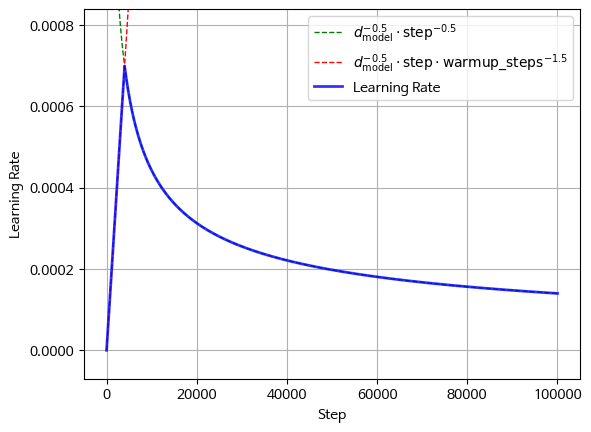

In [34]:
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token 이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시) # 저장된 모델

scheduler_name = 'Noam'

#### Noam ####
# warmup_steps = 4000 # 이건 논문에서 제시한 값 (총 10만 step의 4%)
warmup_steps = 1500 # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려 # 저장된 모델
LR_scale = 0.5 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 녀석 # 저장된 모델



optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0) # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000) # 논문 값
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = 100000)



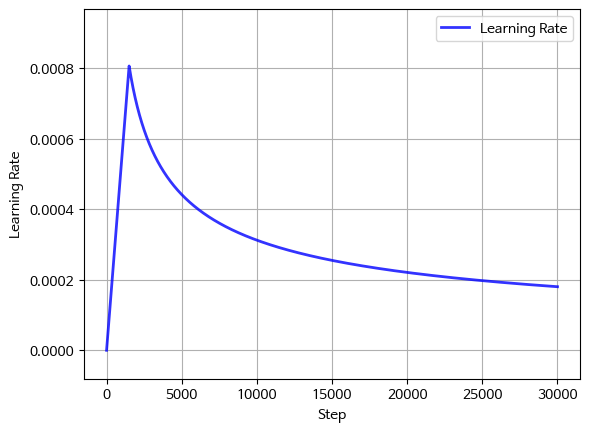

In [35]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_dataset)*EPOCH/BATCH_SIZE)) # 내 상황
